In [179]:
import numpy as np
import cv2 as cv
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import circle_fit as cf

Question 1

Text(0.5, 1.0, 'Points Set')

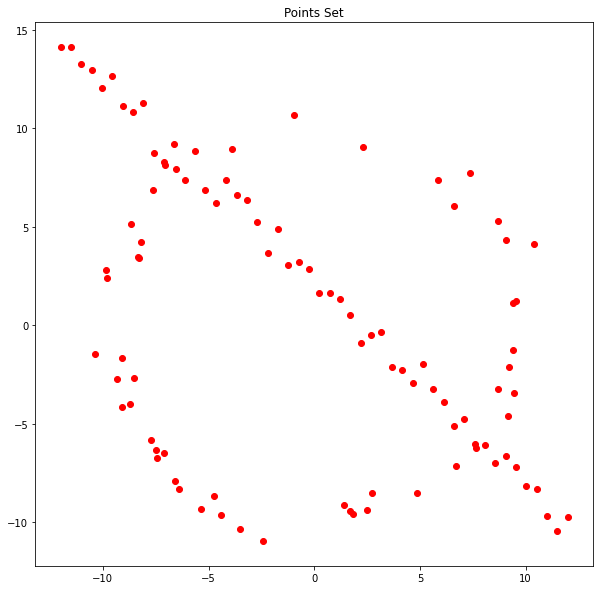

In [180]:
np.random.seed(0)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n , 1) ,y.reshape(half_n, 1 ) ) )
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(X_circ[:,0], X_circ[:,1], 'ro')
ax.plot(X_line[:,0], X_line[:,1], 'ro')

ax.set_title("Points Set")

In [181]:
print(X_circ.shape, X_circ[:,0].shape, X_circ[:,1].shape)


(50, 2) (50,) (50,)


In [182]:
print(X_line[:,0].shape)

(50,)


In [183]:
def estimate_circle(x1, x2, x3):
    try:
        a = 0.5 * ( (x2[1] - x3[1]) * (x1[0]**2 + x1[1]**2 - x2[0]**2 - x2[1]**2) + (x2[1] - x1[1]) * (x2[0]**2 + x2[1]**2 - x3[0]**2 - x3[1]**2) ) / ( (x1[0] - x2[0]) * (x2[1] - x3[1]) - (x2[1] - x1[1]) * (x3[0] - x2[0]) )
        b = 0.5 * ( (x1[0] - x2[0]) * (x2[0]**2 + x2[1]**2 - x3[0]**2 - x3[1]**2) + (x3[0] - x2[0]) * (x1[0]**2 + x1[1]**2 - x2[0]**2 - x2[1]**2) ) / ( (x1[0] - x2[0]) * (x2[1] - x3[1]) - (x2[1] - x1[1]) * (x3[0] - x2[0]) )
        c = -x3[0]**2 - x3[1]**2 + 2*a*x3[0] + 2*b*x3[1]
    except ZeroDivisionError:
        print(f"x1:{x1}\nx2:{x2}\nx3:{x3}")
        return

    r = np.sqrt(a**2 + b**2 - c)

    return a, b, r

def get_circle(x1, x2, x3):
    a, b, r = estimate_circle(x1, x2, x3)

    circle = plt.Circle((a, b), r, color='b', fill=False)

    return circle

def get_inlier_count(a, b, r, X, t):
    count = 0
    best_fit_inliers = None

    for i in range(X.shape[0]):
        distance = abs( ( (X[i,0] - a)**2 + (X[i,1] - b)**2 ) ** 0.5 - r )

        if distance < t:
            count += 1

            if type(best_fit_inliers) == type(None):
                best_fit_inliers = np.array([X[i,:]])
            else:
                best_fit_inliers = np.concatenate((best_fit_inliers, X[i,:].reshape(1, -1)), axis=0)
    
    return count, best_fit_inliers

def RANSAC_circle(X):
    # Parameter for the RANSAC algorithm 
    s = 3
    t = 1.96
    d = 50
    N = 35

    best_fit_circle = None
    best_fit_x = None
    best_inlier_count = 0

    for _ in range(N):
        x = []

        for i in range(s):
            hold = X[np.random.randint(0, 100), :]
            
            if len(x) == 0:
                x.append(hold)
            elif np.array_equal(hold, x[-1]):                
                while np.array_equal(hold, x[-1]):
                    hold = X[np.random.randint(0, 100), :]
                
                x.append(hold)
            else:
                x.append(hold)
        
        a, b, r = estimate_circle(x[0], x[1], x[2])

        count, inliers = get_inlier_count(a, b, r, X, t)

        if count >= d:
            best_fit_circle = plt.Circle((a, b), r, color='b', fill=False, label="Best Sample")
            best_fit_x = x
            best_fit_inliers = inliers
            break            
        elif count > best_inlier_count:
            best_fit_circle = plt.Circle((a, b), r, color='b', fill=False)
            best_fit_x = x
            best_fit_inliers = inliers
            best_inlier_count = count
    
    xc,yc,r,_ = cf.least_squares_circle(best_fit_inliers)

    ransac_circle = plt.Circle((xc, yc), r, color='m', fill=False, label="RANSAC")
    
    return ransac_circle, best_fit_circle, best_fit_x, best_fit_inliers

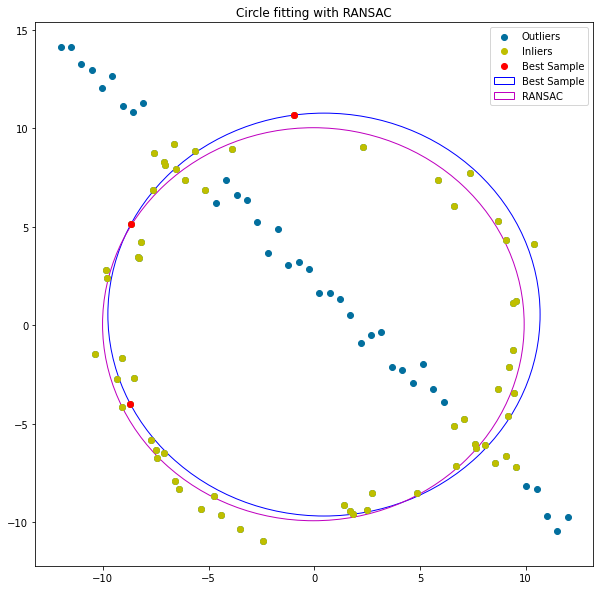

In [184]:
ransac_circle, best_fit_circle, x, inliers = RANSAC_circle(X)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.scatter(X_circ[:,0], X_circ[:,1], color="#026f9e")
ax.scatter(X_line[:,0], X_line[:,1], color="#026f9e", label="Outliers")

if type(inliers) != type(None):
    for point in inliers:
        if np.array_equal(point, inliers[-1]):
            ax.plot(point[0], point[1], 'yo', label="Inliers")
        else:
            ax.plot(point[0], point[1], 'yo')


for point in x:
    if np.array_equal(point, x[-1]):
        ax.plot(point[0], point[1], 'ro', label="Best Sample")
    else:
        ax.plot(point[0], point[1], 'ro')

ax.add_patch(best_fit_circle)
ax.add_patch(ransac_circle)
ax.set_title("Circle fitting with RANSAC")
ax.legend(loc="upper right")


Question 2


In [185]:
def click_event(event, x, y, flags, params):
    global coordinates
    global count
    global first_image

    if event == cv.EVENT_LBUTTONDOWN:
        coordinates.append([x, y])
        count += 1

        first_image = cv.circle(first_image, (x,y), 2, (0, 0, 1), -1)
        cv.imshow("Image", first_image)        
    
    if count == 4:
        cv.destroyAllWindows()


(-0.5, 603.5, 452.5, -0.5)

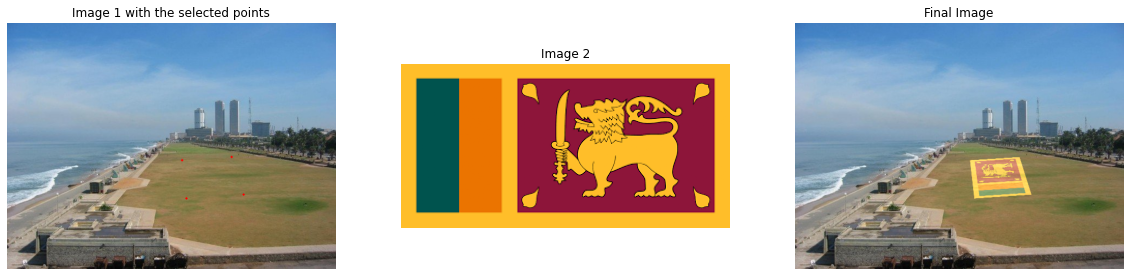

In [186]:
image_1 = cv.imread(r"Images\galle_face.jpg")
image_2 = cv.imread(r"Images\sri_lanka_flag.png")

info = np.iinfo(image_1.dtype) 
image_1 = image_1.astype(np.float64) / info.max

info = np.iinfo(image_2.dtype) 
image_2 = image_2.astype(np.float64) / info.max

first_image = np.copy(image_1)

coordinates = []
count = 0

cv.imshow("Image", image_1)

cv.setMouseCallback("Image", click_event)
cv.waitKey(0)

if len(coordinates) < 4:
    print("You have selected less than 4 points. Please select 4 points")

cv.destroyAllWindows()

# Input parameters
X = np.array([
    [0, 0, 1],
    [image_2.shape[1], 0, 1],
    [image_2.shape[1], image_2.shape[0], 1],
    [0, image_2.shape[0], 1]
]).T

Y = np.array([
    [coordinates[0][0], coordinates[0][1], 1],
    [coordinates[1][0], coordinates[1][1], 1],
    [coordinates[2][0], coordinates[2][1], 1],
    [coordinates[3][0], coordinates[3][1], 1],
]).T

O = np.array([
    [0],
    [0],
    [0]
])

A = []

for i in range(4):
    A.append(np.concatenate((O.T, np.expand_dims(X.T[i,:], axis=0), np.expand_dims(-1*Y[1, i]*X.T[i,:], axis=0) ), axis=1))
    A.append(np.concatenate((np.expand_dims(X.T[i,:], axis=0), O.T, np.expand_dims(-1*Y[0, i]*X.T[i,:], axis=0) ), axis=1))

A = np.array(A).squeeze().astype(np.float64)

eigen_values, eigen_vectors = np.linalg.eig(A.T @ A)
H = eigen_vectors[:, np.argmin(eigen_values)]
H = H.reshape(3, -1)

t_image_2 = cv.warpPerspective(image_2, H, (image_1.shape[1], image_1.shape[0]))

beta = 0.5
blended_img = cv.addWeighted(image_1, 1, t_image_2, beta, 0.0)
blended_img[blended_img > 1] = 1

first_image_rgb = cv.cvtColor(first_image.astype(np.float32), cv.COLOR_BGR2RGB) 
image_2_rgb = cv.cvtColor(image_2.astype(np.float32), cv.COLOR_BGR2RGB)
blended_img_rgb = cv.cvtColor(blended_img.astype(np.float32), cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(first_image_rgb)
ax[1].imshow(image_2_rgb)
ax[2].imshow(blended_img_rgb)

ax[0].set_title("Image 1 with the selected points")
ax[1].set_title("Image 2")
ax[2].set_title("Final Image")

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")

Question 3


254 (640, 800) 254 (640, 800)


(-0.5, 1599.5, 639.5, -0.5)

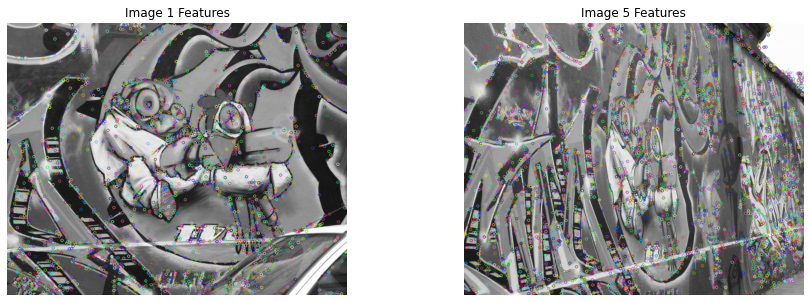

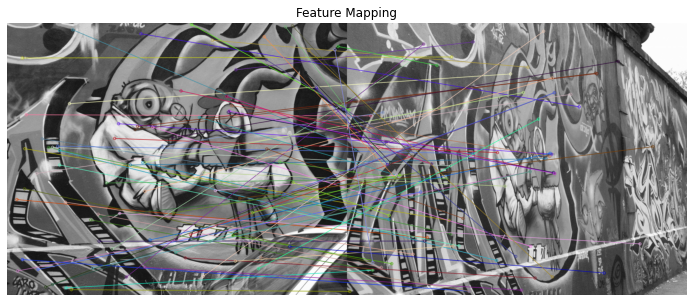

In [303]:
img1 = cv.imread(r"Images\graf\img1.ppm")
img5 = cv.imread(r"Images\graf\img5.ppm")

img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

print(np.max(img1_gray), img1_gray.shape, np.max(img5_gray), img5_gray.shape)

sift = cv.SIFT_create() 

keypoints_1, descriptors_1 = sift.detectAndCompute(img1_gray, None) 
keypoints_2, descriptors_2 = sift.detectAndCompute(img5_gray, None)  

keypoints_img_1 = np.zeros(img1_gray.shape)
keypoints_img_5 = np.zeros(img5_gray.shape)

keypoints_img_1 = cv.drawKeypoints(img1_gray, keypoints_1, keypoints_img_1)
keypoints_img_5 = cv.drawKeypoints(img5_gray, keypoints_2, keypoints_img_5)

bf = cv.BFMatcher()
matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)

# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks = 50)
# flann = cv.FlannBasedMatcher(index_params, search_params)
# matches = flann.knnMatch(descriptors_1,descriptors_2,k=2)

# Apply ratio test
good_matches = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append([m])

matches_img = np.zeros(img1_gray.shape)
matches_img_fifty = np.zeros(img1_gray.shape)

matches_img = cv.drawMatchesKnn(img1_gray, keypoints_1, img5_gray, keypoints_2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#matches_img_fifty = cv.drawMatches(img1_gray, keypoints_1, img5_gray, keypoints_2, matches[:50], matches_img_fifty, flags=2)

good_matches = np.squeeze(np.array(good_matches))

img1_gray = img1_gray.astype(np.float64) / 255
img5_gray = img5_gray.astype(np.float64) / 255

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig2, ax2 = plt.subplots(1, 1, figsize=(15, 5))
#fig3, ax3 = plt.subplots(1, 1, figsize=(15, 5))

ax[0].imshow(keypoints_img_1)
ax[1].imshow(keypoints_img_5)
ax2.imshow(matches_img)
#ax3.imshow(matches_img_fifty)

ax[0].set_title("Image 1 Features")
ax[1].set_title("Image 5 Features")
ax2.set_title("Feature Mapping")
#ax3.set_title("Feature Mapping (First 50 Matches)")

ax[0].axis("off")
ax[1].axis("off")
ax2.axis("off")
#ax3.axis("off")

# cv.imshow("image", img1)
# cv.waitKey(0)
# cv.imshow("image", img5)
# cv.waitKey(0)
# cv.destroyAllWindows()

In [304]:
def get_homography(X, Y):
    O = np.array([
        [0],
        [0],
        [0]
    ])

    A = []

    for i in range(4):
        A.append(np.concatenate((O.T, np.expand_dims(X.T[i,:], axis=0), np.expand_dims(-1*Y[1, i]*X.T[i,:], axis=0) ), axis=1))
        A.append(np.concatenate((np.expand_dims(X.T[i,:], axis=0), O.T, np.expand_dims(-1*Y[0, i]*X.T[i,:], axis=0) ), axis=1))

    A = np.array(A).squeeze().astype(np.float64)

    eigen_values, eigen_vectors = np.linalg.eig(A.T @ A)
    H = eigen_vectors[:, np.argmin(eigen_values)]
    H = H.reshape(3, -1)

    return H

def get_inlier_count(X_full, Y_full, H, t):
    count = 0

    t_X_full = H @ X_full
    t_X_full = t_X_full / t_X_full[2,:]

    error = np.sqrt(np.sum(np.square(t_X_full - Y_full), axis=0))

    count = np.where(error <= t)[0].shape[0]

    return count

def RANSAC(kp1, kp2, matches, t, d, N):
    # Parameter for the RANSAC algorithm 
    s = 4

    best_fit_homography = None
    best_inlier_count = 0
    count_db = []

    X_full = np.zeros((len(matches), 3))
    Y_full = np.zeros((len(matches), 3))

    for i, match in enumerate(matches):
        p1 = kp1[match.queryIdx].pt
        p2 = kp2[match.trainIdx].pt

        X_full[i,:] = np.array([p1[0], p1[1], 1])
        Y_full[i,:] = np.array([p2[0], p2[1], 1])
    
    X_full = X_full.T
    Y_full = Y_full.T

    for _ in range(N):
        x = []

        for i in range(s):
            hold_idx = np.random.randint(0, len(matches))
            
            if len(x) == 0:
                x.append(hold_idx)
            elif hold_idx == x[-1]:                
                while hold_idx == x[-1]:
                    hold_idx = np.random.randint(0, len(matches))
                
                x.append(hold_idx)
            else:
                x.append(hold_idx)
        
        X = np.zeros((4,3))
        Y = np.zeros((4,3))

        for i, idx in enumerate(x):
            match = matches[idx]

            p1 = kp1[match.queryIdx].pt
            p2 = kp2[match.trainIdx].pt

            X[i,:] = np.array([p1[0], p1[1], 1])
            Y[i,:] = np.array([p2[0], p2[1], 1])

        X = X.T
        Y = Y.T

        H = get_homography(X, Y)

        count = get_inlier_count(X_full, Y_full, H, t)

        count_db.append(count)

        if count > best_inlier_count:
            best_fit_homography = H
            best_inlier_count = count
    
    # TODO: Add a way to get the homography from all the inliers

    #ransac_circle = plt.Circle((xc, yc), r, color='m', fill=False, label="RANSAC")
    
    return best_fit_homography, best_inlier_count, count_db

49954.0873029713
7
[[-1.05177706e-04 -4.51807141e-04  1.02947681e-01]
 [-1.01159218e-03 -4.39007400e-03  9.94674960e-01]
 [-1.76504525e-06 -7.58190845e-06  1.72863092e-03]]
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]
7


Text(0.5, 1.0, 'Final Stitched Image')

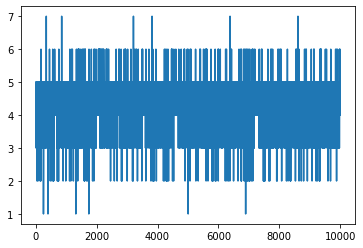

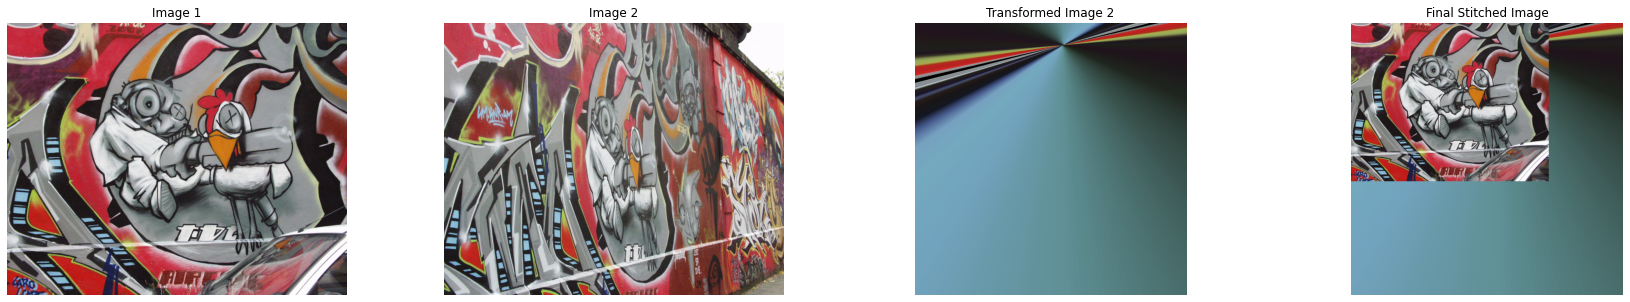

In [307]:
with open("Images\graf\H1to5p", "r") as txt_file:
    actual_H = txt_file.read()
    actual_H = actual_H.split('\n')
    actual_H.pop()

    for i in range(len(actual_H)):
        actual_H[i] = list(map(float, actual_H[i].strip().split()))
    
    actual_H = np.array(actual_H)

d = len(good_matches) * 0.8

H, count, count_db = RANSAC(keypoints_1, keypoints_2, good_matches, 1, d, 10000)

error = np.sum(np.square(actual_H - H))

print(error)
print(count)

print(H)
print(actual_H)

plt.plot(count_db)
print(max(count_db))

final_img = cv.warpPerspective(img5, np.linalg.inv(H),dsize=(1100, 1100))
t_img_5 = np.copy(final_img)
final_img[0:img1.shape[0], 0:img1.shape[1]] = img1

fig, ax = plt.subplots(1, 4, figsize=(30, 5))

ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
ax[2].imshow(cv.cvtColor(t_img_5, cv.COLOR_BGR2RGB))
ax[3].imshow(cv.cvtColor(final_img, cv.COLOR_BGR2RGB))

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
ax[3].axis("off")

ax[0].set_title("Image 1")
ax[1].set_title("Image 2")
ax[2].set_title("Transformed Image 2")
ax[3].set_title("Final Stitched Image")


Rough work


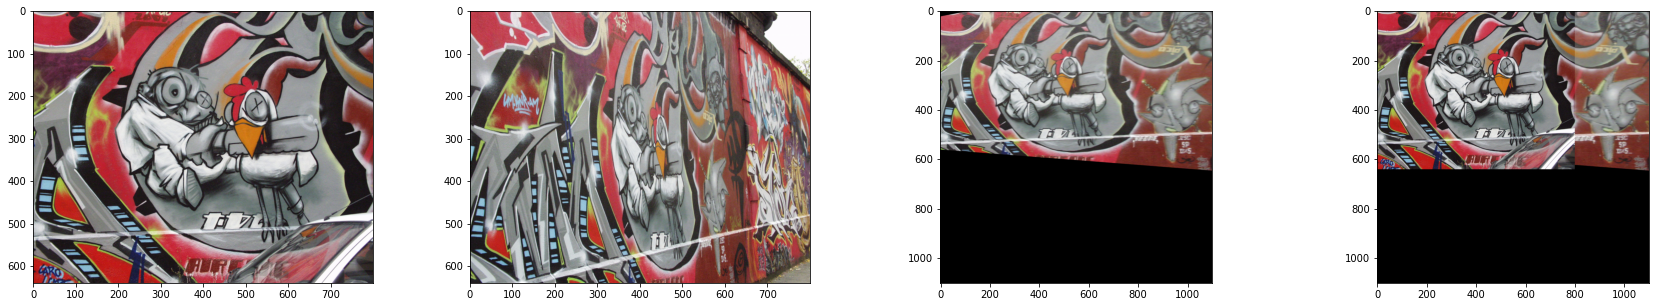

In [306]:
final_img = cv.warpPerspective(img5, np.linalg.inv(actual_H),dsize=(1100, 1100))
t_img_5 = np.copy(final_img)
final_img[0:img1.shape[0], 0:img1.shape[1]] = img1

fig, ax = plt.subplots(1, 4, figsize=(30, 5))

ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
ax[2].imshow(cv.cvtColor(t_img_5, cv.COLOR_BGR2RGB))
ax[3].imshow(cv.cvtColor(final_img, cv.COLOR_BGR2RGB))


In [272]:
z = cv.warpPerspective(img1, H, dsize=(1000, 1000))
w = cv.warpPerspective(img5, np.linalg.inv(H),dsize=(img1.shape[1], img1.shape[0]))
k = cv.warpPerspective(img5, np.linalg.inv(H),dsize=(1000, 1000))

blended_img = cv.addWeighted(img1, 0.5, w, 0.5, 0.0)
#blended_img[blended_img > 1] = 1
k[0:img1.shape[0], 0:img1.shape[1]] = img1

cv.imshow("image", img1)
cv.waitKey(0)
cv.imshow("image", z)
cv.waitKey(0)
cv.imshow("image", img5)
cv.waitKey(0)
cv.imshow("image", w)
cv.waitKey(0)
cv.imshow("image", blended_img)
cv.waitKey(0)
cv.imshow("image", k)
cv.waitKey(0)
cv.destroyAllWindows()

In [263]:
print(img1.shape, k.shape)

(640, 800, 3) (1000, 1000, 3)


In [247]:
 # Get the good key points positions
sourcePoints = np.float32([keypoints_1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
destinationPoints = np.float32([keypoints_2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
# obtain the homography matrix
M, mask = cv.findHomography(sourcePoints, destinationPoints, method=cv.RANSAC, ransacReprojThreshold=5.0)

In [241]:
type(keypoints_1[0].pt[0])

float

In [229]:
good_matches = np.squeeze(np.array(good_matches))

(87,)

In [ ]:
len(good_matches)

43

In [ ]:
X_full = np.zeros((len(matches), 3))
Y_full = np.zeros((len(matches), 3))

for i, match in enumerate(matches):
    p1 = kp1[match.queryIdx].pt
    p2 = kp2[match.trainIdx].pt

    X_full[i,:] = np.array([p1[0], p1[1], 1])
    Y_full[i,:] = np.array([p2[0], p2[1], 1])

X_full = X_full.T
Y_full = Y_full.T

print(X_full.shape, Y_full.shape, len(matches))


(3, 616) (3, 616) 616


In [ ]:
t = 0.01
diff = np.absolute(img1_gray - img5_gray)
print(diff)
print(np.where(diff < t)[0].shape)
count = np.where(diff < t)[0].shape[0]
print(count)

[[116 113  95 ...  29  32  24]
 [108 115 114 ...  36  29  26]
 [114 113 114 ...  33  33  30]
 ...
 [ 40  38  40 ... 141 140 145]
 [ 37  47  49 ... 139 139 135]
 [ 47  47  45 ... 142 142 133]]
(2297,)
2297


In [ ]:
kp1 = keypoints_1
kp2 = keypoints_2

s = 4
x = []

for i in range(s):
    hold_idx = np.random.randint(0, len(matches))
    
    if len(x) == 0:
        x.append(hold_idx)
    elif hold_idx == x[-1]:                
        while hold_idx == x[-1]:
            hold_idx = np.random.randint(0, len(matches))
        
        x.append(hold_idx)
    else:
        x.append(hold_idx)

X = np.zeros((4,3))
Y = np.zeros((4,3))

for i, idx in enumerate(x):
    match = matches[idx]

    p1 = kp1[match.queryIdx].pt
    p2 = kp2[match.trainIdx].pt

    X[i,:] = np.array([p1[0], p1[1], 1])
    Y[i,:] = np.array([p2[0], p2[1], 1])

X = X.T
Y = Y.T

In [ ]:
print(X)
print(Y)

[[375.61312866 331.94177246  22.98262405 224.3187561 ]
 [524.43426514 431.22415161 385.159729   383.51330566]
 [  1.           1.           1.           1.        ]]
[[652.03210449 694.14880371 273.9019165  349.3114624 ]
 [339.7772522   49.78458786 471.56936646 429.85797119]
 [  1.           1.           1.           1.        ]]


In [ ]:
print(img1_gray.shape, img5_gray.shape, img1_gray.shape[0]*img1_gray.shape[1], len(matches))

(640, 800) (640, 800) 512000 616


In [ ]:
np.array([1,2,3,4]).shape[0]

4